In [1]:
# Loading neccessary libraries

import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# Setting GPU for further computing

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Loading Data

In [3]:
# Transform for images for both train and test
data_transform = transforms.Compose([
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into torch tensor
    transforms.ToTensor()
])

In [69]:
# Loading the data 
train_data = datasets.CIFAR10(
    root='data',
    train = True,
    download = True,
    transform = data_transform,
    target_transform=None
)

test_data = datasets.CIFAR10(
    root='data',
    train = False,
    download = True,
    transform = data_transform,
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Checking shape and label of image
image, label = train_data[0]
image.shape, label

(torch.Size([3, 32, 32]), 6)

In [6]:
# Classes name 
class_names  = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
# Classes name with index
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

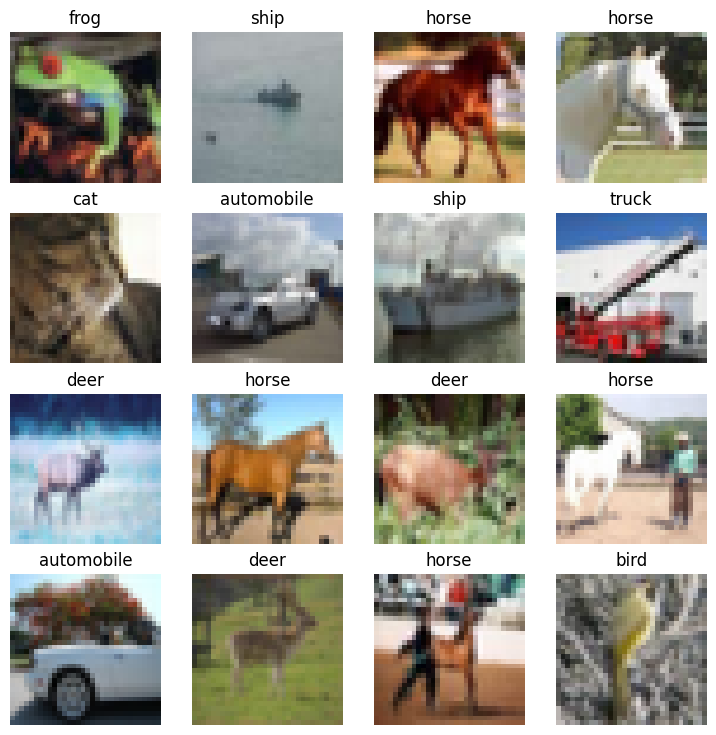

In [8]:
# Visuailizing the train dataset
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data),size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

In [9]:
# Creating dataloader for both train and test

from torch.utils.data import DataLoader

BATCH_SIZE = 32   # Selecting batch size for basic model

# Train dataloader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

# Test dataloader
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [10]:
print(f'Length of train_dataloader:{len(train_dataloader)} of batch size:{BATCH_SIZE}')
print(f'Length of test_dataloader:{len(test_dataloader)} of batch size:{BATCH_SIZE}')

Length of train_dataloader:1563 of batch size:32
Length of test_dataloader:313 of batch size:32


In [67]:
# Defining user defined function for train_step

def train_step(model : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [12]:
# Defining user defined function for test_step

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,0
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)

    test_pred_logits = model(X)
    loss = loss_fn(test_pred_logits,y)
    test_loss+=loss.item()

    test_pred_class = torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
    test_acc+=(test_pred_class==y).sum().item()/len(test_pred_logits)

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc


In [13]:
# Defining user defined function `train` for using both above defined function and print result

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs: int =15,
          device=device):
  results = {'train_loss':[],
             'train_acc':[],
             'test_loss':[],
             'test_acc':[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    print(f'Epoch: {epoch}|Train loss:{train_loss:.4f}|Train acc:{train_acc:.2f}|Test loss:{test_loss:.4f}|Test acc:{test_acc:.2f}')

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

In [14]:
# User defined function for making prediction on test data
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device=device):
  pred_probs=[]
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

## Basic Model

In [15]:
# Intermediate block
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3, activation=nn.ReLU()):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm2d(out_channels),
                activation,
                nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1),
                nn.Dropout(0.2),

                nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm2d(out_channels),
                activation,
                nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1),
                nn.Dropout(0.25),

                nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm2d(out_channels),
                activation,
                nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)

            ))
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        a = torch.softmax(self.fc(m), dim=1)  # Calculate 'a' using a fully connected layer
        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv(x) for i, conv in enumerate(self.conv_layers))
        return x_prime


# Output block which takes input of last intermediate block output image
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_fc_layers=1, activation=nn.ReLU()):
        super(OutputBlock, self).__init__()
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(num_fc_layers - 1)])
        self.fc_layers.append(nn.Linear(in_channels, num_classes))  # Final layer to num_classes
        self.activation = activation

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        for fc in self.fc_layers[:-1]:
            m = self.activation(fc(m))
        o = self.fc_layers[-1](m)
        #print(o.shape)
        return o

# Basic model that uses both intermeidate block and output block to make predictions
class Model_0(nn.Module):
    def __init__(self, input_channels, hidden_units, output_shape, num_blocks, num_conv_layers):
        super(Model_0, self).__init__()
        self.num_blocks = num_blocks
        # First intermediate block with input_channels to hidden_units
        self.conv_block_1 = IntermediateBlock(input_channels, hidden_units, num_conv_layers)
        # Additional intermediate blocks
        self.intermediate_blocks = nn.ModuleList([
            IntermediateBlock(hidden_units, hidden_units, num_conv_layers) for _ in range(num_blocks - 1)
        ])
        # Output block
        self.output_block = OutputBlock(hidden_units, output_shape)

    def forward(self, x):
        x = self.conv_block_1(x)
        for block in self.intermediate_blocks:
            x = block(x)
        x = self.output_block(x)
        return x


In [16]:
model_basic = Model_0(input_channels=3,           # Number of input channels (assuming RGB image)
                  hidden_units=64,            # Number of hidden units in intermediate blocks
                  output_shape=len(class_names),  # Number of classes
                  num_blocks=3,               # Number of intermediate blocks
                  num_conv_layers=2).to(device)   # Number of convolutional layers per block

In [17]:
model_basic

Model_0(
  (conv_block_1): IntermediateBlock(
    (conv_layers): ModuleList(
      (0-1): 2 x Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.2, inplace=False)
        (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU()
        (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (9): Dropout(p=0.25, inplace=False)
        (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU()
        (13): MaxPool2d(kernel_size=3, stride=2, padd

In [18]:
# Runing epochs and saving result for later discussion
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 30


loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

optimizer = torch.optim.Adam(model_basic.parameters(), lr=0.01) # Adam optimizer 


from timeit import default_timer as timer
start_time = timer()

# Training the data
model_basic_results = train(model=model_basic,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=EPOCHS)


end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 0|Train loss:1.7357|Train acc:0.32|Test loss:1.4561|Test acc:0.43
Epoch: 1|Train loss:1.3914|Train acc:0.49|Test loss:1.1326|Test acc:0.59
Epoch: 2|Train loss:1.2056|Train acc:0.58|Test loss:1.0694|Test acc:0.62
Epoch: 3|Train loss:1.0854|Train acc:0.63|Test loss:0.9319|Test acc:0.67
Epoch: 4|Train loss:1.0110|Train acc:0.66|Test loss:0.9780|Test acc:0.67
Epoch: 5|Train loss:0.9495|Train acc:0.68|Test loss:0.8173|Test acc:0.72
Epoch: 6|Train loss:0.9016|Train acc:0.70|Test loss:0.8356|Test acc:0.71
Epoch: 7|Train loss:0.8670|Train acc:0.71|Test loss:0.8269|Test acc:0.72
Epoch: 8|Train loss:0.8333|Train acc:0.72|Test loss:0.7765|Test acc:0.74
Epoch: 9|Train loss:0.8098|Train acc:0.73|Test loss:0.7797|Test acc:0.74
Epoch: 10|Train loss:0.7865|Train acc:0.74|Test loss:0.7636|Test acc:0.75
Epoch: 11|Train loss:0.7668|Train acc:0.75|Test loss:0.7095|Test acc:0.76
Epoch: 12|Train loss:0.7513|Train acc:0.75|Test loss:0.6752|Test acc:0.78
Epoch: 13|Train loss:0.7352|Train acc:0.76|Test 

### Improved model

In [19]:
# Using different transformation for train and test data

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [20]:
# Loading data using transformations 

# Loading train data
train_data = datasets.CIFAR10(
    root='data',
    train = True,
    download = True,
    transform = transform_train,
    target_transform=None
)

# Loading test data
test_data = datasets.CIFAR10(
    root='data',
    train = False,
    download = True,
    transform = transform_test,
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Defining class for DropBlock which is used as part of convolutional layer of intermediate block
class DropBlock(nn.Module):
    def __init__(self, block_size, drop_prob):
        super(DropBlock, self).__init__()
        self.block_size = block_size
        self.drop_prob = drop_prob

    def forward(self, x):
        # Only apply DropBlock during training
        if not self.training or self.drop_prob == 0.0:
            return x
        else:
            # Move mask to the device where x is
            device = x.device
            gamma = self.drop_prob / (self.block_size ** 2)
            mask = (torch.rand(x.shape[0], *x.shape[2:], device=device) < gamma).float()
            
            # Expand mask
            block_mask = F.max_pool2d(mask.unsqueeze(1),
                                      kernel_size=(self.block_size, self.block_size),
                                      stride=(1, 1),
                                      padding=self.block_size // 2)
            
            if self.block_size % 2 == 0:
                block_mask = block_mask[:, :, :-1, :-1]
            
            block_mask = 1 - block_mask.squeeze(1)
            
            # Normalize the features
            x = x * block_mask.unsqueeze(1) * (block_mask.numel() / block_mask.sum().item())
            return x


# Class for intermediate block 
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3, activation=nn.ReLU(),drop_prob=0.1, block_size=7):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm2d(out_channels),
                activation,
                DropBlock(block_size=block_size, drop_prob=drop_prob),
                nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            ))
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        a = torch.softmax(self.fc(m), dim=1)  # Calculate 'a' using a fully connected layer
        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv(x) for i, conv in enumerate(self.conv_layers))
        return x_prime


# Class for OutputBlock
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_fc_layers=1, activation=nn.ReLU()):
        super(OutputBlock, self).__init__()
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(num_fc_layers - 1)])
        self.fc_layers.append(nn.Linear(in_channels, num_classes))  # Final layer to num_classes
        self.activation = activation

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        for fc in self.fc_layers[:-1]:
            m = self.activation(fc(m))
        o = self.fc_layers[-1](m)
        return o

class CustomWideResNet16x8(nn.Module):
    def __init__(self, input_channels, hidden_units, output_shape, num_blocks, num_conv_layers):
        super(CustomWideResNet16x8, self).__init__()
        # Adjusting the hidden_units according to WideResNet 16x8 specs
        self.num_blocks = num_blocks
        # First intermediate block with input_channels to hidden_units
        self.conv_block_1 = IntermediateBlock(input_channels, hidden_units * 8, num_conv_layers)
        # Additional intermediate blocks
        self.intermediate_blocks = nn.ModuleList([
            IntermediateBlock(hidden_units * 8, hidden_units * 8, num_conv_layers) for _ in range(1, num_blocks)
        ])
        # Output block
        self.output_block = OutputBlock(hidden_units * 8, output_shape)

    def forward(self, x):
        x = self.conv_block_1(x)
        for block in self.intermediate_blocks:
            x = block(x)
        x = self.output_block(x)
        return x

In [54]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Initialize the dictionary to store results
hyperparameter_results = {}

# Setting different hyperparameters for tuning the model
EPOCHS = 30
learning_rates = [0.001,0.01]
batch_sizes = [64,128]
optimizers = [torch.optim.Adam]
num_blk = [7,10]
num_clayer = [3,5]


for optimizer_class in optimizers:
    for lr in learning_rates:
        for batch_size in batch_sizes:
          for blk in num_blk:
                for clayer in num_clayer:

                  # Update the DataLoader batch size
                  train_dataloader = DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)
                  test_dataloader = DataLoader(dataset=test_data,
                                              batch_size=batch_size,
                                              shuffle=False)

                  # Initialize model and optimizer with new learning rate and optimizer
                  model_improved = CustomWideResNet16x8(input_channels=3, hidden_units=16, output_shape=10, num_blocks=blk, num_conv_layers=clayer).to(device)
                  optimizer = optimizer_class(model_improved.parameters(), lr=lr)

                  # Train the model
                  model_improved_results = train(model=model_improved,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                optimizer=optimizer,
                                                loss_fn=nn.CrossEntropyLoss(),
                                                epochs=EPOCHS)

                  # Construct unique key for current configuration
                  config_key = f"opt_{optimizer_class.__name__}_lr_{lr}_bs_{batch_size}_blk_{blk}_clayer_{clayer}"

                  # Store results in the dictionary
                  hyperparameter_results[config_key] = model_improved_results

                  # Logging results
                  print(f"Config: {config_key}")
                  print(f"Train Loss: {model_improved_results['train_loss'][-1]}, Train Acc: {model_improved_results['train_acc'][-1]}")
                  print(f"Test Loss: {model_improved_results['test_loss'][-1]}, Test Acc: {model_improved_results['test_acc'][-1]}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.4925|Train acc:0.45|Test loss:1.1809|Test acc:0.58
Epoch: 1|Train loss:1.1031|Train acc:0.60|Test loss:0.9960|Test acc:0.64
Epoch: 2|Train loss:0.9180|Train acc:0.68|Test loss:0.9455|Test acc:0.67
Epoch: 3|Train loss:0.8158|Train acc:0.72|Test loss:0.7706|Test acc:0.74
Epoch: 4|Train loss:0.7351|Train acc:0.75|Test loss:0.7738|Test acc:0.73
Epoch: 5|Train loss:0.6761|Train acc:0.77|Test loss:0.8966|Test acc:0.72
Epoch: 6|Train loss:0.6293|Train acc:0.78|Test loss:0.6352|Test acc:0.78
Epoch: 7|Train loss:0.5865|Train acc:0.80|Test loss:0.6249|Test acc:0.78
Epoch: 8|Train loss:0.5552|Train acc:0.81|Test loss:0.5489|Test acc:0.81
Epoch: 9|Train loss:0.5285|Train acc:0.82|Test loss:0.4917|Test acc:0.83
Epoch: 10|Train loss:0.5104|Train acc:0.83|Test loss:0.6234|Test acc:0.79
Epoch: 11|Train loss:0.4841|Train acc:0.83|Test loss:0.5430|Test acc:0.82
Epoch: 12|Train loss:0.4661|Train acc:0.84|Test loss:0.4853|Test acc:0.84
Epoch: 13|Train loss:0.4471|Train acc:0.84|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.5398|Train acc:0.42|Test loss:1.5409|Test acc:0.44
Epoch: 1|Train loss:1.1067|Train acc:0.60|Test loss:1.0278|Test acc:0.64
Epoch: 2|Train loss:0.9261|Train acc:0.67|Test loss:0.9598|Test acc:0.67
Epoch: 3|Train loss:0.8094|Train acc:0.72|Test loss:1.0641|Test acc:0.64
Epoch: 4|Train loss:0.7276|Train acc:0.75|Test loss:0.6578|Test acc:0.77
Epoch: 5|Train loss:0.6596|Train acc:0.77|Test loss:0.7085|Test acc:0.76
Epoch: 6|Train loss:0.6216|Train acc:0.78|Test loss:0.6214|Test acc:0.78
Epoch: 7|Train loss:0.5751|Train acc:0.80|Test loss:0.7128|Test acc:0.75
Epoch: 8|Train loss:0.5445|Train acc:0.81|Test loss:0.5163|Test acc:0.83
Epoch: 9|Train loss:0.5149|Train acc:0.82|Test loss:0.6258|Test acc:0.79
Epoch: 10|Train loss:0.4904|Train acc:0.83|Test loss:0.5068|Test acc:0.83
Epoch: 11|Train loss:0.4621|Train acc:0.84|Test loss:0.5104|Test acc:0.83
Epoch: 12|Train loss:0.4434|Train acc:0.85|Test loss:0.5222|Test acc:0.82
Epoch: 13|Train loss:0.4253|Train acc:0.85|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.6080|Train acc:0.39|Test loss:1.8238|Test acc:0.38
Epoch: 1|Train loss:1.2120|Train acc:0.56|Test loss:1.2674|Test acc:0.56
Epoch: 2|Train loss:1.0238|Train acc:0.64|Test loss:1.1265|Test acc:0.61
Epoch: 3|Train loss:0.9152|Train acc:0.68|Test loss:0.8594|Test acc:0.70
Epoch: 4|Train loss:0.8226|Train acc:0.71|Test loss:0.8430|Test acc:0.70
Epoch: 5|Train loss:0.7587|Train acc:0.74|Test loss:0.7914|Test acc:0.74
Epoch: 6|Train loss:0.7090|Train acc:0.76|Test loss:0.6847|Test acc:0.76
Epoch: 7|Train loss:0.6739|Train acc:0.77|Test loss:0.6802|Test acc:0.76
Epoch: 8|Train loss:0.6345|Train acc:0.79|Test loss:0.6237|Test acc:0.79
Epoch: 9|Train loss:0.6072|Train acc:0.79|Test loss:0.5291|Test acc:0.82
Epoch: 10|Train loss:0.5771|Train acc:0.81|Test loss:0.5826|Test acc:0.80
Epoch: 11|Train loss:0.5531|Train acc:0.81|Test loss:0.5770|Test acc:0.81
Epoch: 12|Train loss:0.5256|Train acc:0.82|Test loss:0.5430|Test acc:0.82
Epoch: 13|Train loss:0.5026|Train acc:0.83|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.6805|Train acc:0.36|Test loss:1.6707|Test acc:0.39
Epoch: 1|Train loss:1.2395|Train acc:0.55|Test loss:1.3151|Test acc:0.55
Epoch: 2|Train loss:1.0333|Train acc:0.63|Test loss:1.0330|Test acc:0.62
Epoch: 3|Train loss:0.9044|Train acc:0.68|Test loss:0.7971|Test acc:0.73
Epoch: 4|Train loss:0.8179|Train acc:0.72|Test loss:0.7842|Test acc:0.73
Epoch: 5|Train loss:0.7417|Train acc:0.74|Test loss:0.7639|Test acc:0.74
Epoch: 6|Train loss:0.6906|Train acc:0.76|Test loss:0.7497|Test acc:0.75
Epoch: 7|Train loss:0.6456|Train acc:0.78|Test loss:0.6739|Test acc:0.77
Epoch: 8|Train loss:0.6060|Train acc:0.79|Test loss:0.5737|Test acc:0.81
Epoch: 9|Train loss:0.5706|Train acc:0.80|Test loss:0.6079|Test acc:0.79
Epoch: 10|Train loss:0.5440|Train acc:0.81|Test loss:0.5448|Test acc:0.81
Epoch: 11|Train loss:0.5202|Train acc:0.82|Test loss:0.5319|Test acc:0.82
Epoch: 12|Train loss:0.4921|Train acc:0.83|Test loss:0.5220|Test acc:0.82
Epoch: 13|Train loss:0.4711|Train acc:0.84|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.4736|Train acc:0.46|Test loss:1.4467|Test acc:0.51
Epoch: 1|Train loss:1.0555|Train acc:0.63|Test loss:1.1512|Test acc:0.60
Epoch: 2|Train loss:0.8807|Train acc:0.69|Test loss:1.1021|Test acc:0.62
Epoch: 3|Train loss:0.7859|Train acc:0.73|Test loss:1.0191|Test acc:0.65
Epoch: 4|Train loss:0.7136|Train acc:0.75|Test loss:0.7306|Test acc:0.75
Epoch: 5|Train loss:0.6604|Train acc:0.77|Test loss:0.6170|Test acc:0.78
Epoch: 6|Train loss:0.6185|Train acc:0.78|Test loss:0.7103|Test acc:0.76
Epoch: 7|Train loss:0.5761|Train acc:0.80|Test loss:0.5786|Test acc:0.80
Epoch: 8|Train loss:0.5499|Train acc:0.81|Test loss:0.6362|Test acc:0.78
Epoch: 9|Train loss:0.5257|Train acc:0.82|Test loss:0.5768|Test acc:0.81
Epoch: 10|Train loss:0.5035|Train acc:0.83|Test loss:0.6618|Test acc:0.77
Epoch: 11|Train loss:0.4834|Train acc:0.84|Test loss:0.5023|Test acc:0.82
Epoch: 12|Train loss:0.4637|Train acc:0.84|Test loss:0.5306|Test acc:0.82
Epoch: 13|Train loss:0.4435|Train acc:0.85|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.4965|Train acc:0.44|Test loss:1.3974|Test acc:0.48
Epoch: 1|Train loss:1.0727|Train acc:0.61|Test loss:1.0490|Test acc:0.62
Epoch: 2|Train loss:0.8971|Train acc:0.68|Test loss:1.0502|Test acc:0.63
Epoch: 3|Train loss:0.7780|Train acc:0.73|Test loss:0.9266|Test acc:0.68
Epoch: 4|Train loss:0.7003|Train acc:0.75|Test loss:1.1707|Test acc:0.62
Epoch: 5|Train loss:0.6435|Train acc:0.78|Test loss:0.8639|Test acc:0.71
Epoch: 6|Train loss:0.6014|Train acc:0.79|Test loss:0.8593|Test acc:0.71
Epoch: 7|Train loss:0.5678|Train acc:0.80|Test loss:0.7219|Test acc:0.76
Epoch: 8|Train loss:0.5280|Train acc:0.82|Test loss:0.6108|Test acc:0.79
Epoch: 9|Train loss:0.4973|Train acc:0.83|Test loss:0.5045|Test acc:0.83
Epoch: 10|Train loss:0.4747|Train acc:0.84|Test loss:0.6815|Test acc:0.78
Epoch: 11|Train loss:0.4545|Train acc:0.84|Test loss:0.5744|Test acc:0.80
Epoch: 12|Train loss:0.4345|Train acc:0.85|Test loss:0.6522|Test acc:0.79
Epoch: 13|Train loss:0.4155|Train acc:0.85|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.6115|Train acc:0.39|Test loss:1.3777|Test acc:0.50
Epoch: 1|Train loss:1.1868|Train acc:0.57|Test loss:1.1264|Test acc:0.59
Epoch: 2|Train loss:0.9830|Train acc:0.65|Test loss:0.9086|Test acc:0.68
Epoch: 3|Train loss:0.8683|Train acc:0.70|Test loss:0.9242|Test acc:0.68
Epoch: 4|Train loss:0.7879|Train acc:0.73|Test loss:0.8728|Test acc:0.69
Epoch: 5|Train loss:0.7218|Train acc:0.75|Test loss:0.7431|Test acc:0.74
Epoch: 6|Train loss:0.6822|Train acc:0.77|Test loss:0.6722|Test acc:0.77
Epoch: 7|Train loss:0.6358|Train acc:0.78|Test loss:0.6941|Test acc:0.76
Epoch: 8|Train loss:0.6006|Train acc:0.79|Test loss:0.9515|Test acc:0.69
Epoch: 9|Train loss:0.5744|Train acc:0.81|Test loss:0.7731|Test acc:0.75
Epoch: 10|Train loss:0.5492|Train acc:0.81|Test loss:0.7381|Test acc:0.76
Epoch: 11|Train loss:0.5249|Train acc:0.82|Test loss:0.6686|Test acc:0.77
Epoch: 12|Train loss:0.5071|Train acc:0.83|Test loss:0.7605|Test acc:0.75
Epoch: 13|Train loss:0.4874|Train acc:0.83|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.6719|Train acc:0.36|Test loss:1.6527|Test acc:0.37
Epoch: 1|Train loss:1.2435|Train acc:0.54|Test loss:1.0733|Test acc:0.62
Epoch: 2|Train loss:1.0236|Train acc:0.64|Test loss:1.0736|Test acc:0.63
Epoch: 3|Train loss:0.8967|Train acc:0.68|Test loss:0.9548|Test acc:0.67
Epoch: 4|Train loss:0.7989|Train acc:0.72|Test loss:0.8122|Test acc:0.72
Epoch: 5|Train loss:0.7374|Train acc:0.75|Test loss:0.7599|Test acc:0.74
Epoch: 6|Train loss:0.6825|Train acc:0.77|Test loss:0.9499|Test acc:0.69
Epoch: 7|Train loss:0.6388|Train acc:0.78|Test loss:0.7369|Test acc:0.76
Epoch: 8|Train loss:0.5997|Train acc:0.79|Test loss:0.7095|Test acc:0.76
Epoch: 9|Train loss:0.5679|Train acc:0.81|Test loss:0.6447|Test acc:0.78
Epoch: 10|Train loss:0.5355|Train acc:0.82|Test loss:0.6799|Test acc:0.77
Epoch: 11|Train loss:0.5105|Train acc:0.83|Test loss:0.5629|Test acc:0.81
Epoch: 12|Train loss:0.4929|Train acc:0.83|Test loss:0.8337|Test acc:0.74
Epoch: 13|Train loss:0.4715|Train acc:0.84|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.7382|Train acc:0.34|Test loss:1.5068|Test acc:0.42
Epoch: 1|Train loss:1.3488|Train acc:0.51|Test loss:1.1245|Test acc:0.60
Epoch: 2|Train loss:1.1600|Train acc:0.58|Test loss:0.9719|Test acc:0.65
Epoch: 3|Train loss:1.0462|Train acc:0.63|Test loss:0.8443|Test acc:0.71
Epoch: 4|Train loss:0.9583|Train acc:0.66|Test loss:0.8655|Test acc:0.70
Epoch: 5|Train loss:0.9001|Train acc:0.68|Test loss:0.6707|Test acc:0.77
Epoch: 6|Train loss:0.8492|Train acc:0.70|Test loss:0.7325|Test acc:0.74
Epoch: 7|Train loss:0.8159|Train acc:0.71|Test loss:0.6464|Test acc:0.78
Epoch: 8|Train loss:0.7905|Train acc:0.72|Test loss:0.6772|Test acc:0.76
Epoch: 9|Train loss:0.7608|Train acc:0.73|Test loss:0.6124|Test acc:0.79
Epoch: 10|Train loss:0.7334|Train acc:0.74|Test loss:0.6507|Test acc:0.77
Epoch: 11|Train loss:0.7185|Train acc:0.75|Test loss:0.5863|Test acc:0.80
Epoch: 12|Train loss:0.7051|Train acc:0.75|Test loss:0.5782|Test acc:0.80
Epoch: 13|Train loss:0.6818|Train acc:0.76|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.7201|Train acc:0.35|Test loss:1.6094|Test acc:0.44
Epoch: 1|Train loss:1.3389|Train acc:0.51|Test loss:1.4036|Test acc:0.52
Epoch: 2|Train loss:1.1630|Train acc:0.58|Test loss:0.9782|Test acc:0.66
Epoch: 3|Train loss:1.0419|Train acc:0.62|Test loss:0.9064|Test acc:0.67
Epoch: 4|Train loss:0.9705|Train acc:0.65|Test loss:0.8028|Test acc:0.72
Epoch: 5|Train loss:0.9073|Train acc:0.68|Test loss:0.8605|Test acc:0.70
Epoch: 6|Train loss:0.8532|Train acc:0.70|Test loss:0.7369|Test acc:0.74
Epoch: 7|Train loss:0.8103|Train acc:0.72|Test loss:0.6358|Test acc:0.78
Epoch: 8|Train loss:0.7780|Train acc:0.73|Test loss:0.7172|Test acc:0.76
Epoch: 9|Train loss:0.7483|Train acc:0.74|Test loss:0.5994|Test acc:0.79
Epoch: 10|Train loss:0.7227|Train acc:0.75|Test loss:0.5517|Test acc:0.81
Epoch: 11|Train loss:0.7080|Train acc:0.75|Test loss:0.6066|Test acc:0.79
Epoch: 12|Train loss:0.6845|Train acc:0.76|Test loss:0.5963|Test acc:0.80
Epoch: 13|Train loss:0.6725|Train acc:0.76|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.9204|Train acc:0.25|Test loss:1.6365|Test acc:0.34
Epoch: 1|Train loss:1.5740|Train acc:0.39|Test loss:1.4392|Test acc:0.45
Epoch: 2|Train loss:1.3762|Train acc:0.49|Test loss:1.1618|Test acc:0.58
Epoch: 3|Train loss:1.2005|Train acc:0.57|Test loss:1.0811|Test acc:0.61
Epoch: 4|Train loss:1.0938|Train acc:0.61|Test loss:0.9221|Test acc:0.68
Epoch: 5|Train loss:1.0160|Train acc:0.64|Test loss:0.8451|Test acc:0.70
Epoch: 6|Train loss:0.9570|Train acc:0.66|Test loss:0.8005|Test acc:0.73
Epoch: 7|Train loss:0.9174|Train acc:0.68|Test loss:0.9397|Test acc:0.68
Epoch: 8|Train loss:0.8736|Train acc:0.69|Test loss:0.6827|Test acc:0.77
Epoch: 9|Train loss:0.8402|Train acc:0.71|Test loss:0.6919|Test acc:0.77
Epoch: 10|Train loss:0.8126|Train acc:0.72|Test loss:0.6542|Test acc:0.77
Epoch: 11|Train loss:0.7880|Train acc:0.72|Test loss:0.6100|Test acc:0.79
Epoch: 12|Train loss:0.7681|Train acc:0.73|Test loss:0.5910|Test acc:0.80
Epoch: 13|Train loss:0.7493|Train acc:0.74|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:2.0180|Train acc:0.22|Test loss:1.7491|Test acc:0.30
Epoch: 1|Train loss:1.6884|Train acc:0.35|Test loss:1.5055|Test acc:0.41
Epoch: 2|Train loss:1.4916|Train acc:0.44|Test loss:1.3358|Test acc:0.52
Epoch: 3|Train loss:1.3174|Train acc:0.52|Test loss:1.1410|Test acc:0.60
Epoch: 4|Train loss:1.1761|Train acc:0.58|Test loss:1.0053|Test acc:0.65
Epoch: 5|Train loss:1.0856|Train acc:0.61|Test loss:0.9952|Test acc:0.65
Epoch: 6|Train loss:1.0164|Train acc:0.64|Test loss:0.9826|Test acc:0.65
Epoch: 7|Train loss:0.9559|Train acc:0.66|Test loss:0.7273|Test acc:0.75
Epoch: 8|Train loss:0.9017|Train acc:0.68|Test loss:0.9606|Test acc:0.67
Epoch: 9|Train loss:0.8660|Train acc:0.70|Test loss:0.7083|Test acc:0.76
Epoch: 10|Train loss:0.8354|Train acc:0.71|Test loss:0.6921|Test acc:0.76
Epoch: 11|Train loss:0.8016|Train acc:0.72|Test loss:0.6552|Test acc:0.79
Epoch: 12|Train loss:0.7864|Train acc:0.72|Test loss:0.6506|Test acc:0.78
Epoch: 13|Train loss:0.7595|Train acc:0.73|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.7443|Train acc:0.33|Test loss:1.4364|Test acc:0.45
Epoch: 1|Train loss:1.3523|Train acc:0.50|Test loss:1.1313|Test acc:0.60
Epoch: 2|Train loss:1.1405|Train acc:0.59|Test loss:1.1621|Test acc:0.58
Epoch: 3|Train loss:1.0185|Train acc:0.64|Test loss:0.9226|Test acc:0.67
Epoch: 4|Train loss:0.9367|Train acc:0.67|Test loss:0.8363|Test acc:0.71
Epoch: 5|Train loss:0.8721|Train acc:0.69|Test loss:0.8999|Test acc:0.69
Epoch: 6|Train loss:0.8203|Train acc:0.71|Test loss:0.7017|Test acc:0.76
Epoch: 7|Train loss:0.7754|Train acc:0.73|Test loss:0.7097|Test acc:0.76
Epoch: 8|Train loss:0.7451|Train acc:0.74|Test loss:0.6476|Test acc:0.78
Epoch: 9|Train loss:0.7284|Train acc:0.75|Test loss:0.6525|Test acc:0.79
Epoch: 10|Train loss:0.7036|Train acc:0.75|Test loss:0.5735|Test acc:0.80
Epoch: 11|Train loss:0.6844|Train acc:0.76|Test loss:0.5643|Test acc:0.80
Epoch: 12|Train loss:0.6636|Train acc:0.76|Test loss:0.5373|Test acc:0.81
Epoch: 13|Train loss:0.6476|Train acc:0.77|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.7629|Train acc:0.33|Test loss:1.4894|Test acc:0.45
Epoch: 1|Train loss:1.3442|Train acc:0.51|Test loss:1.4640|Test acc:0.47
Epoch: 2|Train loss:1.1378|Train acc:0.59|Test loss:0.9397|Test acc:0.67
Epoch: 3|Train loss:1.0132|Train acc:0.63|Test loss:0.9980|Test acc:0.65
Epoch: 4|Train loss:0.9328|Train acc:0.67|Test loss:0.8480|Test acc:0.70
Epoch: 5|Train loss:0.8708|Train acc:0.69|Test loss:0.8077|Test acc:0.72
Epoch: 6|Train loss:0.8185|Train acc:0.71|Test loss:0.7012|Test acc:0.76
Epoch: 7|Train loss:0.7825|Train acc:0.72|Test loss:0.6792|Test acc:0.77
Epoch: 8|Train loss:0.7540|Train acc:0.74|Test loss:0.7926|Test acc:0.73
Epoch: 9|Train loss:0.7249|Train acc:0.75|Test loss:0.6349|Test acc:0.78
Epoch: 10|Train loss:0.7058|Train acc:0.75|Test loss:0.5397|Test acc:0.81
Epoch: 11|Train loss:0.6796|Train acc:0.76|Test loss:0.6091|Test acc:0.79
Epoch: 12|Train loss:0.6573|Train acc:0.77|Test loss:0.5750|Test acc:0.80
Epoch: 13|Train loss:0.6474|Train acc:0.77|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.9070|Train acc:0.25|Test loss:2.0505|Test acc:0.26
Epoch: 1|Train loss:1.5751|Train acc:0.39|Test loss:1.4879|Test acc:0.43
Epoch: 2|Train loss:1.3613|Train acc:0.49|Test loss:1.1744|Test acc:0.57
Epoch: 3|Train loss:1.1748|Train acc:0.57|Test loss:1.2640|Test acc:0.55
Epoch: 4|Train loss:1.0765|Train acc:0.61|Test loss:0.9326|Test acc:0.68
Epoch: 5|Train loss:0.9848|Train acc:0.65|Test loss:0.8734|Test acc:0.69
Epoch: 6|Train loss:0.9292|Train acc:0.67|Test loss:0.7589|Test acc:0.74
Epoch: 7|Train loss:0.8839|Train acc:0.69|Test loss:0.7677|Test acc:0.74
Epoch: 8|Train loss:0.8441|Train acc:0.70|Test loss:0.8338|Test acc:0.71
Epoch: 9|Train loss:0.8026|Train acc:0.72|Test loss:0.5999|Test acc:0.79
Epoch: 10|Train loss:0.7853|Train acc:0.73|Test loss:0.6082|Test acc:0.79
Epoch: 11|Train loss:0.7532|Train acc:0.73|Test loss:0.6556|Test acc:0.77
Epoch: 12|Train loss:0.7246|Train acc:0.74|Test loss:0.6738|Test acc:0.77
Epoch: 13|Train loss:0.7181|Train acc:0.75|Test 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0|Train loss:1.9277|Train acc:0.25|Test loss:1.6930|Test acc:0.34
Epoch: 1|Train loss:1.5923|Train acc:0.38|Test loss:1.4835|Test acc:0.46
Epoch: 2|Train loss:1.3969|Train acc:0.49|Test loss:1.2652|Test acc:0.53
Epoch: 3|Train loss:1.2090|Train acc:0.57|Test loss:1.2686|Test acc:0.55
Epoch: 4|Train loss:1.0968|Train acc:0.61|Test loss:0.9780|Test acc:0.65
Epoch: 5|Train loss:1.0005|Train acc:0.64|Test loss:0.8921|Test acc:0.68
Epoch: 6|Train loss:0.9612|Train acc:0.66|Test loss:0.8186|Test acc:0.71
Epoch: 7|Train loss:0.9094|Train acc:0.68|Test loss:0.7321|Test acc:0.75
Epoch: 8|Train loss:0.8664|Train acc:0.70|Test loss:0.6620|Test acc:0.77
Epoch: 9|Train loss:0.8315|Train acc:0.71|Test loss:0.6834|Test acc:0.76
Epoch: 10|Train loss:0.8066|Train acc:0.72|Test loss:0.8322|Test acc:0.72
Epoch: 11|Train loss:0.7789|Train acc:0.73|Test loss:0.6563|Test acc:0.78
Epoch: 12|Train loss:0.7472|Train acc:0.74|Test loss:0.6489|Test acc:0.78
Epoch: 13|Train loss:0.7324|Train acc:0.74|Test 

In [70]:
best_config = None
best_test_acc = 0

# Iterate over all results to find the best test accuracy among all
for config_key, results in hyperparameter_results.items():
    if results['test_acc'][-1] > best_test_acc:  # Compare using the last epoch's test accuracy
        best_test_acc = results['test_acc'][-1]
        best_config = config_key


# Printing the best config and accuracy: 
print(f"Best Configuration: {best_config}")
print(f"Best Test Accuracy: {best_test_acc}")


Best Configuration: opt_Adam_lr_0.001_bs_64_blk_7_clayer_5
Best Test Accuracy: 0.8818670382165605


In [71]:
# Get the test accuracy of basic model
basic_test_acc = model_basic_results['test_acc'][-1]

# Comparing
print(f"Basic Model Test Accuracy: {basic_test_acc}")
print(f"Best Improved Model Test Accuracy: {best_test_acc}")

# Finding which model is better
if best_test_acc > basic_test_acc:
    print("The improved model performs better than the basic model.")
else:
    print("The basic model performs better than the improved model.")


Basic Model Test Accuracy: 0.8247803514376997
Best Improved Model Test Accuracy: 0.8818670382165605
The improved model performs better than the basic model.


In [72]:
best_improved_results = hyperparameter_results[best_config]

# Creating  DataFrame
compare_results = pd.DataFrame({
    "Model": ["Basic Model", "Best Improved Model"],
    "Final Train Loss": [model_basic_results['train_loss'][-1], best_improved_results['train_loss'][-1]],
    "Final Train Accuracy": [model_basic_results['train_acc'][-1], best_improved_results['train_acc'][-1]],
    "Final Test Loss": [model_basic_results['test_loss'][-1], best_improved_results['test_loss'][-1]],
    "Final Test Accuracy": [model_basic_results['test_acc'][-1], best_improved_results['test_acc'][-1]],
})

# Table
compare_results

,Model,Final Train Loss,Final Train Accuracy,Final Test Loss,Final Test Accuracy
0,Basic Model,0.594021,0.804802,0.530998,0.824780
1,Best Improved Model,0.241319,0.916061,0.368046,0.881867


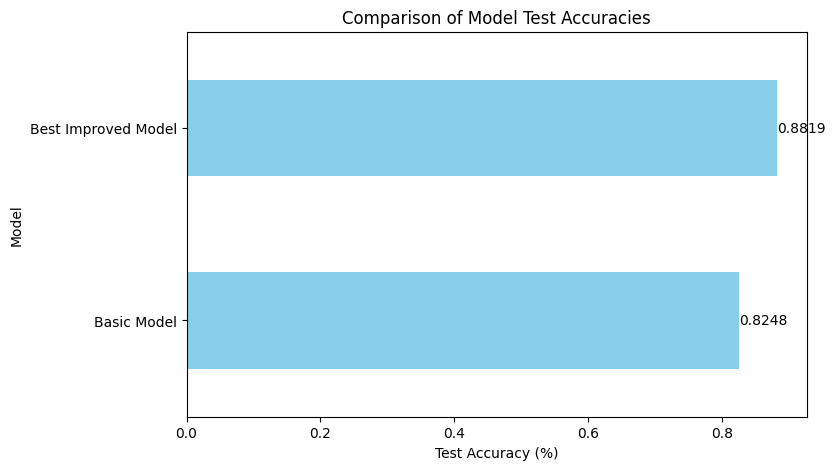

In [76]:
# Set the model name 
compare_results.set_index('Model', inplace=True)

# Create bar plot
ax = compare_results['Final Test Accuracy'].plot(kind='barh', figsize=(8, 5), color='skyblue')

# Data labels 
for p in ax.patches:
    ax.text(p.get_width(), p.get_y() + p.get_height() / 2,
            f'{p.get_width():.4f}',  # format the number
            va='center')

# Labels and title
plt.xlabel('Test Accuracy (%)')
plt.ylabel('Model')
plt.title('Comparison of Model Test Accuracies')
plt.show()

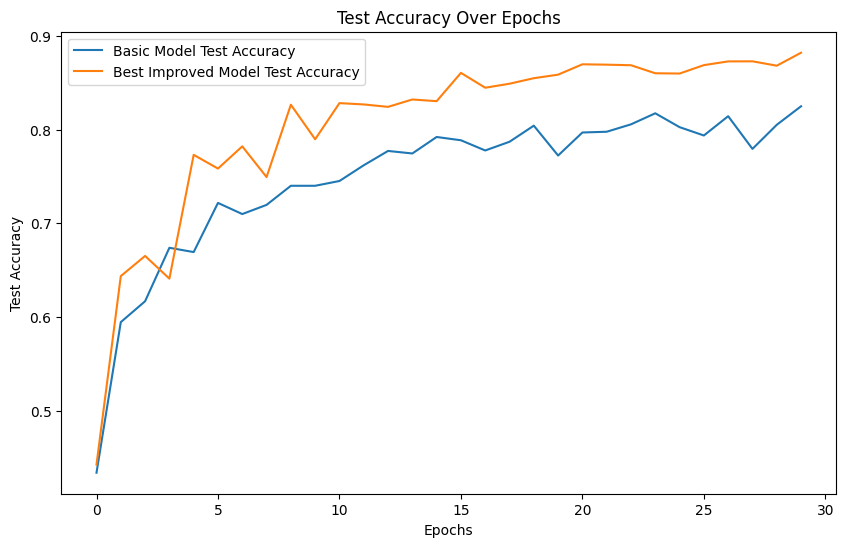

In [77]:
# Plotting  test accuracy
plt.figure(figsize=(10, 6))
plt.plot(model_basic_results['test_acc'], label='Basic Model Test Accuracy')
plt.plot(hyperparameter_results[best_config]['test_acc'], label='Best Improved Model Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()


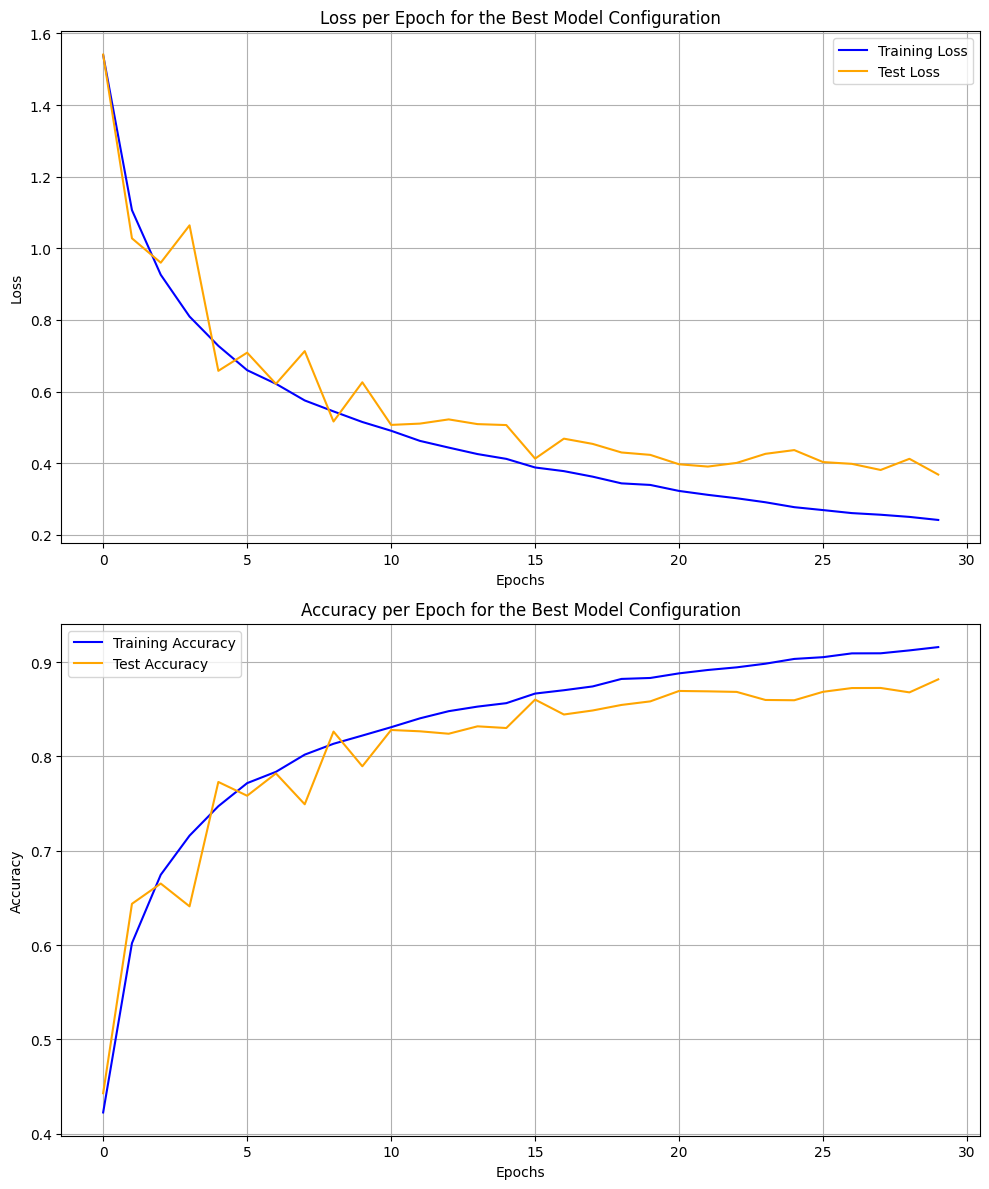

In [112]:
# Replace 'best_config_key' with the actual key of your best configuration.
best_config_key = 'opt_Adam_lr_0.001_bs_64_blk_7_clayer_5'

# Extract the results
best_train_loss = hyperparameter_results[best_config_key]['train_loss']
best_train_acc = hyperparameter_results[best_config_key]['train_acc']
best_test_loss = hyperparameter_results[best_config_key]['test_loss']
best_test_acc = hyperparameter_results[best_config_key]['test_acc']

# Create a figure
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot of the loss 
axs[0].plot(best_train_loss, label='Training Loss', color='blue')
axs[0].plot(best_test_loss, label='Test Loss', color='orange')
axs[0].set_title('Loss per Epoch for the Best Model Configuration')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot of the training accuracy and testing accuracy
axs[1].plot(best_train_acc, label='Training Accuracy', color='blue')
axs[1].plot(best_test_acc, label='Test Accuracy', color='orange')
axs[1].set_title('Accuracy per Epoch for the Best Model Configuration')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# Plotting
plt.tight_layout()
plt.show()


In [86]:
import random
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)
test_samples[0].shape

torch.Size([3, 32, 32])

In [87]:
# Make predictions

pred_probs = make_predictions(model=model_improved,
                              data=test_samples)

# View first two predictions probabilities
pred_probs[:2]

tensor([[8.1152e-03, 7.4110e-04, 5.9798e-02, 4.4389e-01, 3.4836e-01, 8.4557e-02,
         1.7836e-02, 1.9839e-02, 1.4171e-02, 2.6992e-03],
        [5.0203e-03, 2.8293e-04, 1.2109e-01, 4.4441e-01, 1.9010e-01, 2.0612e-01,
         8.4205e-03, 2.0846e-02, 3.2405e-03, 4.7611e-04]])

In [111]:
# Convert prediction probabilites to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 3, 3, 3, 4, 3, 3, 3, 4])

In [84]:
# Comparing pred_classes with test_lables 
test_labels

[9, 2, 1, 3, 7, 3, 7, 0, 9]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


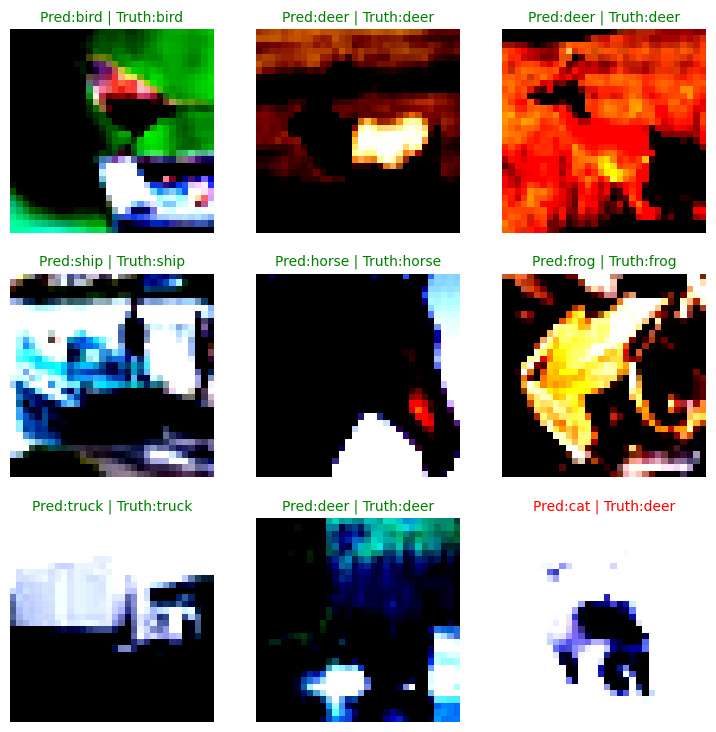

In [64]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0))

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    # Create a title for the plot
    title_text = f'Pred:{pred_label} | Truth:{truth_label}'

    # Colour based on prediction and true label
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')

    plt.axis('off') 

# Plotting
plt.show()

In [65]:
from tqdm.auto import tqdm
# Make predictions with trained model
y_preds=[]
model_improved.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc='Making predictions...'):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_improved(X)
    # Turn predictions  from logits-> predcition probabilities->prediction labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # Put precitions on CPU for evaulation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/79 [00:00<?, ?it/s]

tensor([3, 8, 0, 0, 6, 3, 1, 4, 3, 1])

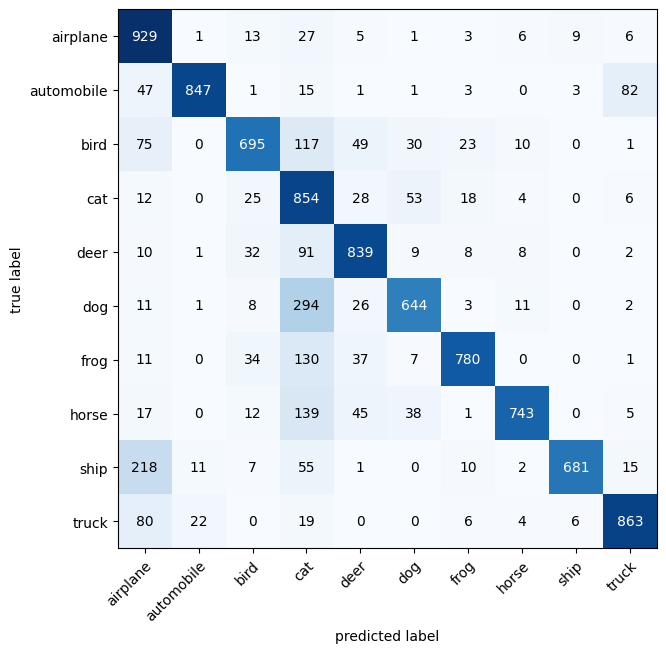

In [66]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_pred_tensor = torch.cat(y_preds)
test_targets_tensor = torch.tensor(test_data.targets)

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass',num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_targets_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotplib works with numpy
    class_names=class_names,
    figsize=(10,7)
)